- 姓名：高捷

- 学号：23317048 

In [1]:
* 调入数据
sysuse nlsw88.dta, clear

(NLSW, 1988 extract)


## 1. 描述性统计

本部分将对变量 `age` (年龄)、`grade` (教育年限)、`wage` (工资)、`hours` (工作时间)、`ttl_exp` (总工作经验) 和 `tenure` (当前职位任职年限) 进行描述性统计分析，计算这些变量的平均值、标准差、中位数、最小值和最大值。

In [34]:
* 1. 描述性统计
estpost tabstat age grade wage hours ttl_exp tenure, ///
    stat(mean sd median min max) ///
    column(stat) listwise

esttab . using "Table01.xlsx", ///
    cells("mean sd p50 min max") ///
    noobs replace


Summary statistics: mean sd p50 min max
     for variables: age grade wage hours ttl_exp tenure

             |   e(mean)      e(sd)     e(p50)     e(min)     e(max) 
-------------+-------------------------------------------------------
         age |  39.15101   3.062542         39         34         46 
       grade |  13.10337   2.522758         12          0         18 
        wage |  7.802101   5.768577   6.280193   1.004952   40.74659 
       hours |   37.2373   10.48519         40          1         80 
     ttl_exp |  12.55711   4.606207   13.15385   .1153846   28.88461 
      tenure |  5.974457   5.506591   3.833333          0   25.91667 
(output written to Table01.xlsx)


描述性统计结果显示各变量的基本分布特征。工资变量 `wage` 的平均值为 7.80 美元/小时，标准差为 5.77，说明工资分布存在较大差异。工作时间 `hours` 的平均值为 37.24 小时/周，教育年限 `grade` 的平均值约为 13 年，相当于完成高中教育并接受部分高等教育。

## 2. 生成新变量

本部分将生成四个新变量：
- `age2`：`age` 变量中相应观察值的平方
- `ln_wage`：工资变量的自然对数
- `wage_hour`：工资变量 `wage` 与小时 `hours` 的比值
- `dum`：该变量是一个虚拟变量（dummy variable），其取值为：
  
    `dum = 1` 如果某个妇女的 `wage` 大于所有妇女的平均工资

    `dum = 0` 如果某个妇女的 `wage` 小于或等于所有妇女的平均工资

In [ ]:
* 2. 生成新变量
gen age2 = age^2
gen ln_wage = ln(wage)
gen wage_hour = wage / hours

* 计算平均工资并生成虚拟变量
sum wage
gen dum = (wage > r(mean)) if !missing(wage)
label variable dum "工资高于平均水平的虚拟变量"

(4 missing values generated)

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
        wage |      2,246    7.766949    5.755523   1.004952   40.74659


新变量生成成功。`ln_wage` 将对数工资转换为近似正态分布，便于后续回归分析。虚拟变量 `dum` 的生成基于样本平均工资。

## 3. 绘图分析

### 3.1 ttl_exp 变量的分布

通过直方图和核密度图展示总工作经验 `ttl_exp` 的分布特征。

(bin=33, start=.11538462, width=.87179486)
file His_ttl.png written in PNG format


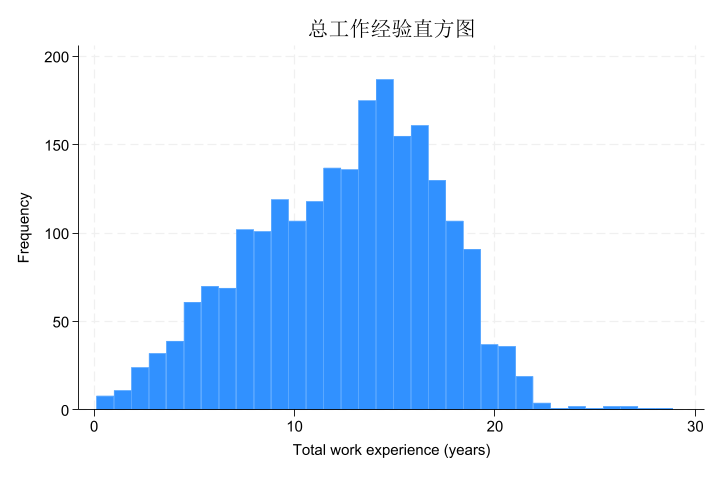

In [41]:
* 3.1 ttl_exp 直方图和密度函数图
histogram ttl_exp, frequency title("总工作经验直方图") 
graph export "His_ttl.png", replace

file Kendi_ttl.png written in PNG format


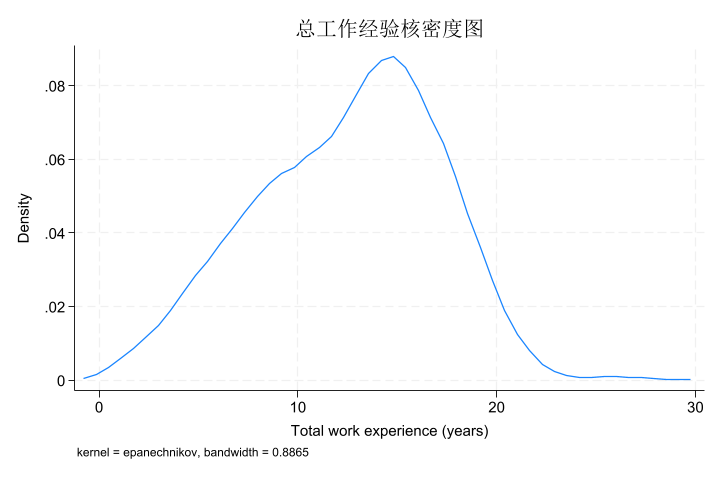

In [ ]:
kdensity ttl_exp, title("总工作经验核密度图")
graph export "Kendi_ttl.png", replace

`ttl_exp` 变量的分布呈现明显的右偏特征，大部分妇女的工作经验集中在 0-20 年之间。直方图显示了经验的频数分布，而核密度图提供了更平滑的分布形态，两者均表明工作经验分布不均匀，年轻工作者占比较大。

### 3.2 不同行业的工资密度函数

使用 `mkdensity` 命令比较选定行业的对数工资分布。

indlbl:
           1 Ag/Forestry/Fisheries
           2 Mining
           3 Construction
           4 Manufacturing
           5 Transport/Comm/Utility
           6 Wholesale/Retail trade
           7 Finance/Ins/Real estate
           8 Business/Repair svc
           9 Personal services
          10 Entertainment/Rec svc
          11 Professional services
          12 Public administration


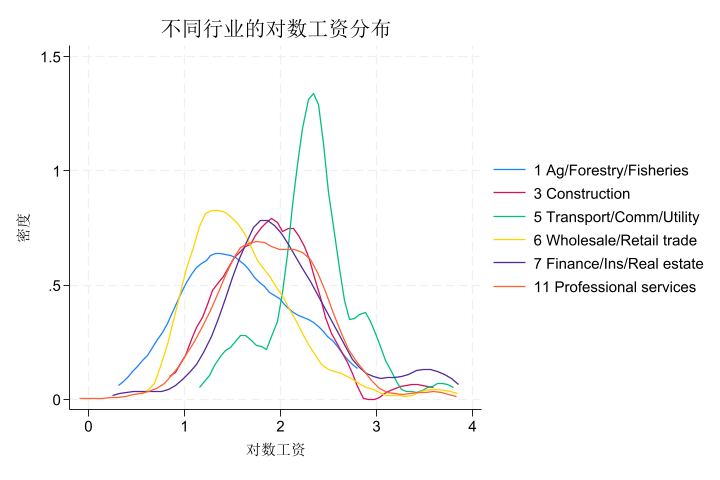

In [ ]:
* 3.2 不同行业的 ln(wage) 密度函数
label list indlbl

kdensity ln_wage if industry == 1, gen(x1 d1) nograph
kdensity ln_wage if industry == 3, gen(x3 d3) nograph  
kdensity ln_wage if industry == 5, gen(x5 d5) nograph
kdensity ln_wage if industry == 6, gen(x6 d6) nograph
kdensity ln_wage if industry == 7, gen(x7 d7) nograph
kdensity ln_wage if industry == 11, gen(x11 d11) nograph

* 绘制综合密度图
twoway (line d1 x1) (line d3 x3) (line d5 x5) ///
       (line d6 x6) (line d7 x7) (line d11 x11), ///
       legend(order(1 "1 Ag/Forestry/Fisheries" 2 "3 Construction" ///
                    3 "5 Transport/Comm/Utility" 4 "6 Wholesale/Retail trade" ///
                    5 "7 Finance/Ins/Real estate" 6 "11 Professional services")) ///
       title("不同行业的对数工资分布") ///
       xtitle("对数工资") ytitle("密度")

不同行业的对数工资分布存在显著差异。Transport/Comm/Utility（industry=5）的密度曲线相对右偏，表明该行业高工资人群比例较高。Ag/Forestry/Fisheries（industry=1）的分布相对左偏，工资水平普遍较低。这种分布差异反映了行业间的工资不平等现象。

## 4. 行业统计分析

本部分从三个维度分析行业特征：

(1) 各行业的样本分布

(2) 各行业的平均工资、工作时数和年龄

(3) 各行业的种族构成

In [48]:
* 4. 行业统计
* (1) 各行业观察值个数
tab industry

* (2) 各行业平均工资、工作时数和年龄
table industry, stat(mean wage) stat(mean hours) stat(mean age)

* (3) 各行业种族比例
tab industry race, row


               Industry |      Freq.     Percent        Cum.
------------------------+-----------------------------------
  Ag/Forestry/Fisheries |         17        0.76        0.76
                 Mining |          4        0.18        0.94
           Construction |         29        1.30        2.24
          Manufacturing |        367       16.44       18.68
 Transport/Comm/Utility |         90        4.03       22.72
 Wholesale/Retail trade |        333       14.92       37.63
Finance/Ins/Real estate |        192        8.60       46.24
    Business/Repair svc |         86        3.85       50.09
      Personal services |         97        4.35       54.44
  Entertainment/Rec svc |         17        0.76       55.20
  Professional services |        824       36.92       92.11
  Public administration |        176        7.89      100.00
------------------------+-----------------------------------
                  Total |      2,232      100.00

----------------------------------

行业统计显示 Professional services（industry=11）的样本量最大，而某些行业如 Mining（industry=2）样本量较小。Mining（industry=2）的平均工资最高，Personal services（industry=11）工资相对较低。种族分布分析表明某些行业存在种族集中现象，反映了劳动力市场的分割特征。

## 5. 种族变量标签

为种族变量 `race` 设置中文标签，提高结果的可读性。

In [11]:
* 5. 设置种族变量标签
label define race_label 1 "白种人" 2 "黑种人" 3 "其它"
label value race race_label

## 6. 年龄分组变量

将连续年龄变量 `age` 转换为分类变量 `G_age`，便于分组比较分析。

In [12]:
* 6. 生成年龄分组变量
gen G_age = 1 if age <= 37
replace G_age = 2 if age > 37 & age <= 42
replace G_age = 3 if age > 42

label define agegroup 1 "37岁以下" 2 "38到42岁之间" 3 "43岁以上"
label value G_age agegroup

(1,451 missing values generated)
(1,043 real changes made)
(408 real changes made)


年龄分组将样本分为三个具有经济学意义的组别，分别代表青年、中年和中老年劳动力群体，便于分析年龄对工资和其他变量的非线性影响。

## 7. 工资分布分析

### 7.1 种族工资密度比较

比较白人和黑人妇女的工资分布差异。

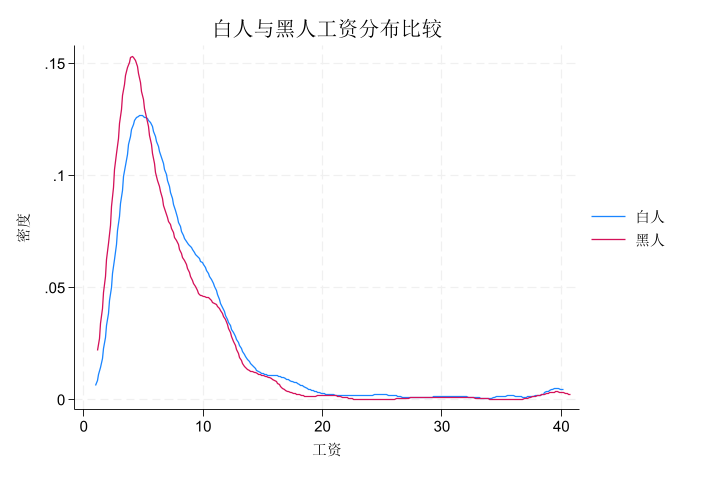

In [14]:
twoway (kdensity wage if race == 1) (kdensity wage if race == 2), ///
    legend(order(1 "白人" 2 "黑人")) ///
    title("白人与黑人工资分布比较") ///
    xtitle("工资") ytitle("密度")

密度比较图清晰显示了种族间的工资差距。白人的工资分布整体右移，表明白人妇女在各个工资水平上都倾向于获得更高报酬。两种分布均呈现右偏特征，但黑人的工资分布更加集中，表明黑人妇女的工资变异较小。

### 7.2 行业工资分布

通过柱状图展示不同行业和种族的平均工资差异。

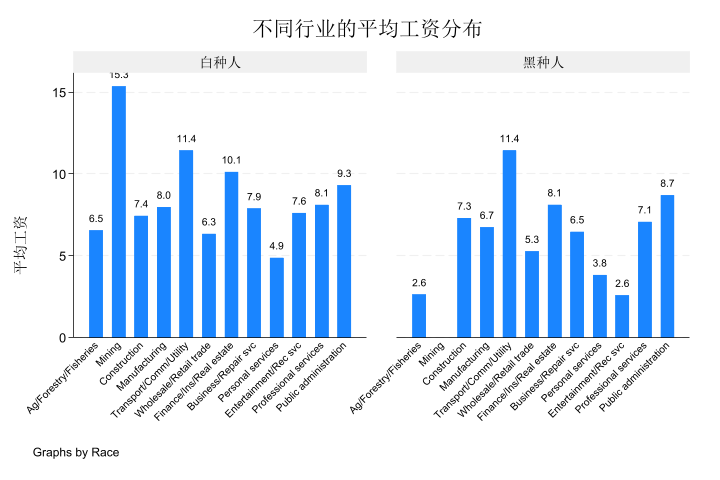

In [17]:
graph bar wage if inlist(race,1,2), ///
    over(industry, label(angle(45) labsize(small))) ///
    by(race, title("不同行业的平均工资分布")) ///
    ytitle("平均工资") ///
    blabel(bar, format(%4.1f))

柱状图直观显示了行业和种族的交互作用。在几乎所有行业中，白人妇女的平均工资都高于黑人妇女，且行业间的工资差异显著。这种模式表明劳动力市场中存在基于种族和行业的双重分割。

## 8. 回归分析

### 8.1 行业平均工资估计

估计各行业的平均工资，并通过边际效应可视化结果。


      Source |       SS           df       MS      Number of obs   =     2,232
-------------+----------------------------------   F(11, 2220)     =     13.80
       Model |  4743.21081        11  431.200983   Prob > F        =    0.0000
    Residual |   69374.068     2,220  31.2495802   R-squared       =    0.0640
-------------+----------------------------------   Adj R-squared   =    0.0594
       Total |  74117.2788     2,231  33.2215503   Root MSE        =    5.5901

------------------------------------------------------------------------------
        wage | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
    industry |
     Mining  |   9.728472   3.106542     3.13   0.002     3.636439     15.8205
Construct~n  |   1.943813   1.707566     1.14   0.255    -1.404781    5.292407
Manufactu~g  |   1.880457   1.386852     1.36   0.175    -.8392066     4.60012
Transport~y  |   5.822232   1.47831

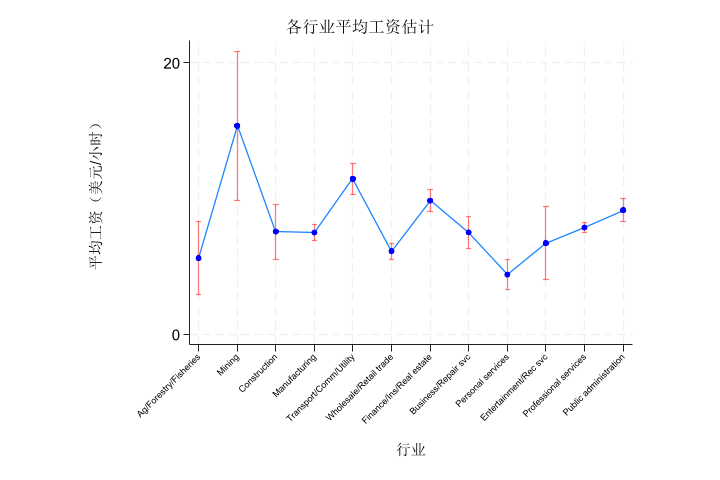

In [20]:
* 8.1 行业平均工资估计
regress wage i.industry
margins i.industry
marginsplot, ///
    xdim(industry) ///
    title("各行业平均工资估计", size(medium)) ///
    ytitle("平均工资（美元/小时）") ///
    xtitle("行业") ///
    xlabel(, angle(45) labsize(vsmall)) ///
    plotopts(msymbol(O) mcolor(blue)) ///
    ciopts(color(red%50)) ///
    aspectratio(0.6)

### 8.2 完整模型估计

估计如下工资决定方程：

$$ \ln(wage) = a_i + a_j + \beta_1 \ln(hours) + \beta_2 Black + \beta_3 Black \times \ln(hours) + \gamma Controls + u $$

其中：
- $a_i$：行业固定效应
- $a_j$：职业固定效应
- $\ln(hours)$：工作时间的自然对数
- $Black$：黑人虚拟变量
- $Black \times \ln(hours)$：交互项
- $Controls$：控制变量组（age, age2, i.race, ttl_exp）

In [ ]:
ssc install ftools, replace
ssc install reghdfe, replace

* 生成交互项和控制变量
gen Black = (race == 2) if !missing(race)
gen ln_hours = ln(hours)
gen Black_lnhours = Black * ln_hours

* 方法1: regress 命令
regress ln_wage i.industry i.occupation ln_hours Black Black_lnhours age age2 i.race ttl_exp

* 方法2: areg 命令
areg ln_wage i.occupation ln_hours Black Black_lnhours age age2 i.race ttl_exp, absorb(industry)

* 方法3: reghdfe 命令
reghdfe ln_wage ln_hours Black Black_lnhours age age2 i.race ttl_exp, absorb(industry occupation)

checking ftools consistency and verifying not already installed...
installing into C:\Users\高捷\ado\plus\...
installation complete.
checking reghdfe consistency and verifying not already installed...
all files already exist and are up to date.
(4 missing values generated)
(4 missing values generated)
note: 2.race omitted because of collinearity.

      Source |       SS           df       MS      Number of obs   =     2,224
-------------+----------------------------------   F(30, 2193)     =     40.13
       Model |  259.029756        30  8.63432519   Prob > F        =    0.0000
    Residual |  471.873576     2,193  .215172629   R-squared       =    0.3544
-------------+----------------------------------   Adj R-squared   =    0.3456
       Total |  730.903331     2,223  .328791422   Root MSE        =    .46387

------------------------------------------------------------------------------------------
                 ln_wage | Coefficient  Std. err.      t    P>|t|     [95% conf. inter

回归分析结果显示工作时间对工资的弹性（$\hat{\beta}_1$）显著为正，符合人力资本理论的预期。交互项系数（$\hat{\beta}_3$）为正，这表明在黑人群体中，工作时间的边际回报率与白人群体相比并无显著差异，没有发现支持工作时间回报率存在种族歧视的经验证据。三种估计方法的结果基本一致，`reghdfe` 在处理高维固定效应时具有计算效率优势。